In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.layers import Dense, LSTM, BatchNormalization
from keras.models import Sequential, load_model

Using TensorFlow backend.


In [2]:
currency_name = 'USDCNY'

In [3]:
df = pd.read_parquet('../Dataframes/df_' + currency_name + '.parquet.gzip')

In [4]:
df.head()

,date,open,high,low,close,delta,wclose,so_3,so_4,so_5,...,hi_avg_2,lo_avg_2,hilo_avg_2,hilo_avg,slope_3,slope_4,slope_5,slope_10,slope_20,slope_30
29,11/2/2000,8.2788,8.2788,8.2788,8.2781,0.0,8.278450,-inf,0.000000,0.000000,...,8.27880,8.27880,8.278800,8.27880,1012.269939,1315.789474,1876.513317,2280.550775,-2469.135802,6445.159119
30,14/2/2000,8.2781,8.2785,8.2778,8.2779,0.0,8.278025,10.000000,10.000000,10.000000,...,8.27865,8.27830,8.278475,8.27815,714.285714,1181.818182,1621.160410,3234.230615,-1871.980676,7772.562250
31,15/2/2000,8.2779,8.2784,8.2775,8.2777,0.0,8.277825,15.384615,15.384615,15.384615,...,8.27845,8.27765,8.278050,8.27795,-1621.621622,1097.852029,1710.097720,3680.246491,-540.241031,8533.838436
32,16/2/2000,8.2777,8.2777,8.2777,8.2777,0.0,8.277700,20.000000,15.384615,15.384615,...,8.27805,8.27760,8.277825,8.27770,3947.368421,-560.747664,1677.852349,3674.328262,2806.881387,8995.530171
33,17/2/2000,8.2777,8.2777,8.2769,8.2772,0.0,8.277250,20.000000,18.750000,15.789474,...,8.27770,8.27730,8.277500,8.27730,7500.000000,5074.626866,357.142857,3682.373473,3711.387736,8986.048219


In [5]:
# swap high price and opening price

# now the second column is now daily high price

def swap_columns(df, c1, c2):
    df['temp'] = df[c1]
    df[c1] = df[c2]
    df[c2] = df['temp']
    df.drop(columns=['temp'], inplace=True)
    df.rename(columns={c1: c2, c2: c1}, inplace=True)
    
swap_columns(df, 'open', 'high')

In [6]:
df.drop(columns=['delta'],inplace=True)
df = df.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

In [7]:
df.head()

,date,high,open,low,close,wclose,so_8,so_9,so_10,wr_6,...,hi_avg_2,lo_avg_2,hilo_avg_2,hilo_avg,slope_3,slope_4,slope_5,slope_10,slope_20,slope_30
29,11/2/2000,8.2788,8.2788,8.2788,8.2781,8.278450,56.250000,56.250000,56.250000,-100.000000,...,8.27880,8.27880,8.278800,8.27880,1012.269939,1315.789474,1876.513317,2280.550775,-2469.135802,6445.159119
30,14/2/2000,8.2785,8.2781,8.2778,8.2779,8.278025,40.000000,43.750000,43.750000,-90.000000,...,8.27865,8.27830,8.278475,8.27815,714.285714,1181.818182,1621.160410,3234.230615,-1871.980676,7772.562250
31,15/2/2000,8.2784,8.2779,8.2775,8.2777,8.277825,15.384615,26.666667,31.250000,-84.615385,...,8.27845,8.27765,8.278050,8.27795,-1621.621622,1097.852029,1710.097720,3680.246491,-540.241031,8533.838436
32,16/2/2000,8.2777,8.2777,8.2777,8.2777,8.277700,15.384615,15.384615,26.666667,-84.615385,...,8.27805,8.27760,8.277825,8.27770,3947.368421,-560.747664,1677.852349,3674.328262,2806.881387,8995.530171
33,17/2/2000,8.2777,8.2777,8.2769,8.2772,8.277250,15.789474,15.789474,15.789474,-84.210526,...,8.27770,8.27730,8.277500,8.27730,7500.000000,5074.626866,357.142857,3682.373473,3711.387736,8986.048219


### Change the normalization to be (0, 1)

In [8]:
data = df

# constants
lookback = 50
batch_size = 512
epoch = 10

# 10% of the data used for testing
test_size = int(.1 * (len(data)-lookback))


# feed the lstm with all features starting from the open price
# still contains the high
input_features = data.iloc[:, 1:].values
input_data = input_features

# train a numpy array of input vectors
sc = MinMaxScaler(feature_range = (0, 1))

input_data[:,:] = sc.fit_transform(input_features[:,:])

In [9]:
input_features

array([[0.99946237, 0.99950858, 0.9995091 , ..., 0.52280551, 0.48765432,
        0.76498853],
       [0.99932796, 0.99919585, 0.99906283, ..., 0.53234231, 0.4906401 ,
        0.77226298],
       [0.99928315, 0.9991065 , 0.99892895, ..., 0.53680246, 0.49729879,
        0.77643492],
       ...,
       [0.45277778, 0.45282345, 0.43685291, ..., 0.50003135, 0.49940514,
        0.72875498],
       [0.45573477, 0.44478199, 0.44278829, ..., 0.50065936, 0.49943825,
        0.72876408],
       [0.44583333, 0.44022516, 0.4366744 , ..., 0.50071296, 0.50025779,
        0.72909782]])

In [10]:
input_data.shape

(4623, 30)

In [11]:
# number of features excluding the target feature
feature_size = input_data.shape[1] - 1
feature_size

29

In [12]:
input_data

array([[0.99946237, 0.99950858, 0.9995091 , ..., 0.52280551, 0.48765432,
        0.76498853],
       [0.99932796, 0.99919585, 0.99906283, ..., 0.53234231, 0.4906401 ,
        0.77226298],
       [0.99928315, 0.9991065 , 0.99892895, ..., 0.53680246, 0.49729879,
        0.77643492],
       ...,
       [0.45277778, 0.45282345, 0.43685291, ..., 0.50003135, 0.49940514,
        0.72875498],
       [0.45573477, 0.44478199, 0.44278829, ..., 0.50065936, 0.49943825,
        0.72876408],
       [0.44583333, 0.44022516, 0.4366744 , ..., 0.50071296, 0.50025779,
        0.72909782]])

In [13]:
input_data[[0],1:]

array([[0.99950858, 0.9995091 , 0.99919585, 0.99935154, 0.09322679,
        0.11854533, 0.11688252, 0.10646674, 0.10594703, 0.09322679,
        0.11854533, 0.11688252, 0.41329451, 0.40453641, 0.41262649,
        0.43289186, 0.99947888, 0.44641281, 0.54093567, 0.99948397,
        0.99950883, 0.99950755, 0.99950772, 0.53374233, 0.53289474,
        0.53753027, 0.52280551, 0.48765432, 0.76498853]])

In [14]:
'''
package data into packs of 50 each, starting from the oldest data
up to len(data) - test_size - lookback - 1

X is excluded from the daily high price: the target value

and convert X and y to numpy array
'''
X = []
y = []
for i in range(len(data)- lookback):
    t = []
    for j in range(lookback):
        t.append(input_data[[(i + j)], 1:])
    X.append(t)
    y.append(input_data[i + lookback, 0])

X, y = np.array(X), np.array(y)

In [15]:
X

array([[[[0.99950858, 0.9995091 , 0.99919585, ..., 0.52280551,
          0.48765432, 0.76498853]],

        [[0.99919585, 0.99906283, 0.9991065 , ..., 0.53234231,
          0.4906401 , 0.77226298]],

        [[0.9991065 , 0.99892895, 0.99901716, ..., 0.53680246,
          0.49729879, 0.77643492]],

        ...,

        [[0.99937455, 0.99937522, 0.99941923, ..., 0.52734694,
          0.48325612, 0.69490356]],

        [[0.99941923, 0.99941985, 0.9996426 , ..., 0.52289759,
          0.49691877, 0.6951676 ]],

        [[0.9996426 , 0.99964298, 0.9996426 , ..., 0.51668092,
          0.51749271, 0.6955205 ]]],


       [[[0.99919585, 0.99906283, 0.9991065 , ..., 0.53234231,
          0.4906401 , 0.77226298]],

        [[0.9991065 , 0.99892895, 0.99901716, ..., 0.53680246,
          0.49729879, 0.77643492]],

        [[0.99901716, 0.99901821, 0.99901716, ..., 0.53674328,
          0.51403441, 0.77896509]],

        ...,

        [[0.99941923, 0.99941985, 0.9996426 , ..., 0.52289759,
       

In [16]:
# test data taken from the latest (size - (test_size + lookback)) data points
X_test = X[-test_size:]

# cut the test data out
X = X[:-(test_size)]
y = y[:-(test_size)]

# reshape
X = X.reshape(X.shape[0], lookback, feature_size)
X_test = X_test.reshape(X_test.shape[0],lookback, feature_size)
X.shape

(4116, 50, 29)

In [17]:
file = "./Models/" + currency_name + ".model"
model = None
if os.path.exists(file):
    model = load_model(file)
else:
    model = Sequential()
    model.add(LSTM(units=30, return_sequences= True, input_shape=(X.shape[1],feature_size)))
    model.add(LSTM(units=30, return_sequences=True))
    model.add(LSTM(units=30))
    model.add(Dense(units=1))
    model.summary()
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X, y, epochs=5, batch_size=32)
    model.save(file)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 30)            7200      
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 30)            7320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 21,871
Trainable params: 21,871
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
4116/4116 [==============================] - 9s 2ms/step - loss: 0.0156
Epoch 2/5
4116/4116 [==============================] - 8s 2ms/step - loss: 1.9268e-04
Epoch 3/5
4116/4116 [==============================] - 7s 2ms/step - loss: 1.249

In [18]:
# put the predicted target value inside input_data

# inverse tranform the predicted data

predicted_value = model.predict(X_test)
li = input_data.shape[0]
lp = predicted_value.shape[0]
for i in range(li - lp, li - 1):
    input_data[i + 1][0] = predicted_value[i - (li - lp)][0]

input_data = sc.inverse_transform(input_data)

input_data = input_data[-(test_size) + 1:,0]

In [19]:
actual_data = data.iloc[:, 1:].values[-(test_size) + 1:,0]
actual_data

array([6.6255, 6.6403, 6.6365, 6.6477, 6.643 , 6.6623, 6.6503, 6.6402,
       6.6377, 6.6132, 6.6392, 6.642 , 6.641 , 6.6437, 6.6441, 6.652 ,
       6.6441, 6.6356, 6.6385, 6.6355, 6.6384, 6.6421, 6.6328, 6.6038,
       6.6066, 6.6074, 6.6091, 6.6185, 6.618 , 6.6172, 6.6206, 6.6194,
       6.6197, 6.6194, 6.6213, 6.6186, 6.6233, 6.6233, 6.6112, 6.6114,
       6.618 , 6.6174, 6.6059, 6.5885, 6.5845, 6.5726, 6.558 , 6.5604,
       6.5594, 6.5317, 6.5317, 6.5037, 6.511 , 6.5105, 6.4908, 6.5006,
       6.5317, 6.5364, 6.5188, 6.4942, 6.4607, 6.4517, 6.4408, 6.4417,
       6.4072, 6.4146, 6.413 , 6.3975, 6.3614, 6.3402, 6.341 , 6.3443,
       6.3317, 6.3073, 6.3028, 6.3103, 6.302 , 6.278 , 6.3445, 6.3333,
       6.3321, 6.3485, 6.3542, 6.3542, 6.3542, 6.3542, 6.3542, 6.3542,
       6.3635, 6.349 , 6.3301, 6.3172, 6.3362, 6.3591, 6.3611, 6.35  ,
       6.3483, 6.3308, 6.3423, 6.3527, 6.3327, 6.3336, 6.3235, 6.325 ,
       6.335 , 6.3373, 6.3346, 6.3355, 6.3355, 6.3343, 6.3163, 6.284 ,
      

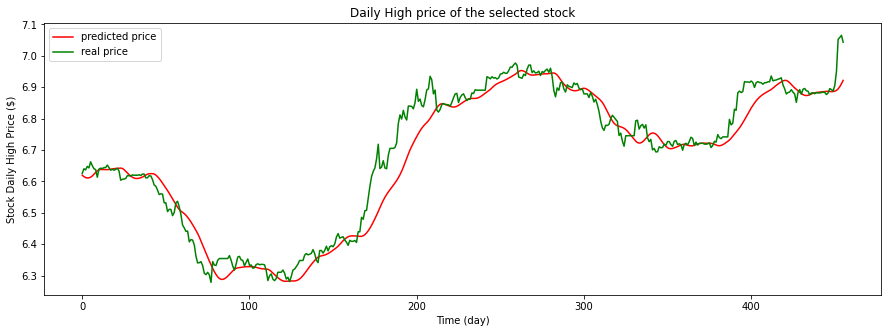

In [20]:
plt.figure(figsize=(15,5))
plt.plot(input_data, color= 'red', label="predicted price")
plt.plot(actual_data, color='green', label="real price")
plt.title("Daily High price of the selected stock")
plt.xlabel("Time (day)")
plt.ylabel("Stock Daily High Price ($)")

plt.legend()

In [21]:
# generate alphas
frame = pd.DataFrame({'actual': actual_data, 'predict': input_data})

In [22]:
frame['p1'] = frame['predict'].shift(1)
frame['diff1'] = frame['predict'] - frame['p1']
frame

,actual,predict,p1,diff1
0,6.6255,6.619658,NaN,NaN
1,6.6403,6.615063,6.619658,-0.004595
2,6.6365,6.612052,6.615063,-0.003011
3,6.6477,6.610811,6.612052,-0.001241
4,6.6430,6.611278,6.610811,0.000467
...,...,...,...,...
451,6.9502,6.889741,6.887367,0.002373
452,7.0526,6.894646,6.889741,0.004905
453,7.0586,6.901790,6.894646,0.007144
454,7.0652,6.911096,6.901790,0.009306


In [23]:
frame['alpha'] = frame['diff1'] / frame['actual'] * 200

In [24]:
frame['wclose'] = data['wclose'].values[-(test_size) + 1:]
frame['pct_change'] = frame['wclose'].pct_change()
frame.head(10)

,actual,predict,p1,diff1,alpha,wclose,pct_change
0,6.6255,6.619658,NaN,NaN,NaN,6.625300,NaN
1,6.6403,6.615063,6.619658,-0.004595,-0.138383,6.633600,0.001253
2,6.6365,6.612052,6.615063,-0.003011,-0.090754,6.633075,-0.000079
3,6.6477,6.610811,6.612052,-0.001241,-0.037327,6.636725,0.000550
4,6.6430,6.611278,6.610811,0.000467,0.014061,6.647950,0.001691
5,6.6623,6.613342,6.611278,0.002064,0.061955,6.650075,0.000320
6,6.6503,6.617351,6.613342,0.004009,0.120573,6.642050,-0.001207
7,6.6402,6.622749,6.617351,0.005398,0.162589,6.633325,-0.001314
8,6.6377,6.628505,6.622749,0.005755,0.173412,6.607475,-0.003897
9,6.6132,6.633635,6.628505,0.005130,0.155158,6.602875,-0.000696


In [25]:
capital = 100000
frame['capital_allocation'] = frame['alpha'] * capital
frame['daily_pnl'] = frame['capital_allocation'] * frame['pct_change']

In [26]:
cumsum = frame['daily_pnl'].cumsum()

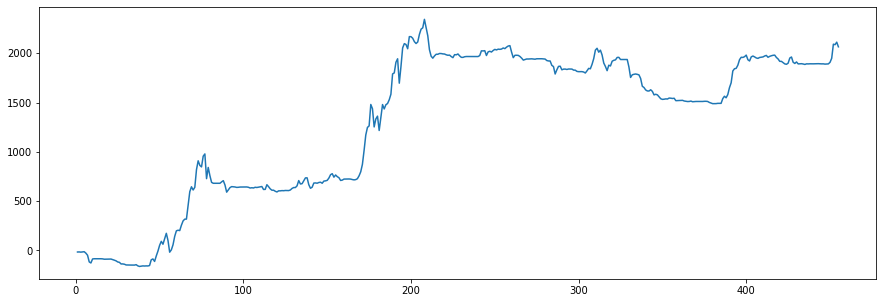

In [27]:
plt.figure(figsize=(15,5))
plt.plot(cumsum)
plt.show()

In [28]:
# calculate sharpe ratio

sharpe = np.sqrt(252) * (frame['daily_pnl'].mean()) / (frame['daily_pnl'].std())
sharpe

1.6046031337165099

In [29]:
# calculate win/loss ratio

wins = 0
losses = 0

length = frame['daily_pnl'].count()

for i in range(length):
    if frame['daily_pnl'][i] > 0:
        wins += 1
    elif frame['daily_pnl'][i] < 0:
        losses += 1

wl = wins / losses
wl

1.1959798994974875

In [30]:
# maximum drawdown
maxm = 0
drawdown = 0
cur_low = 0
size = len(cumsum)

final_start = 0
final_end = 0

start_date = 0
end_date = 0

for i in range(1, size):
    cur_val = cumsum[i]
    if cur_val >= maxm:
        
        drawdown = max(drawdown, maxm - cur_low)
        
        if drawdown == maxm - cur_low:
            final_start = start_date
            final_end = end_date
            
        maxm = cur_val
        cur_low = cur_val
        
        start_date = i
    else:
        cur_low = min(cur_low, cur_val)
        if cur_low == cur_val:
            end_date = i

print('drawdown is:', drawdown, ', from day', final_start, ', to day', final_end)

drawdown is: 387.96055431196953 , from day 77 , to day 90
